#### Automatically Generating Tomogram Masks with SAM2

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import matplotlib.pyplot as plt
import mrcfile, torch, copick 
import my_sam2_utils as utils
from PIL import Image
import numpy as np

# use bfloat16 for the entire notebook.
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )    

using device: cuda


Load Copick Project

In [3]:
copick_config = '/hpc/projects/group.czii/krios1.processing/copick/24jul29c/run001/vatpase_config.json'
name = 'lysosome'

# Open Copick Project and Query All Available Runs
root = copick.from_file(copick_config)
run_ids = [run.name for run in root.runs] 

Pull the Tomograms and labeled Points

In [22]:
runID = 'Position_12_4_Vol'

# Get Run
run = root.get_run(runID)

# Get Tomogram
vol = utils.get_tomogram(run)

# Get Lysosome Centers
points = utils.get_coordinates(run)

Getting denoised Tomogram with 10 A voxel size for the associated runID: Position_12_4_Vol


Quick Inpsection of Data

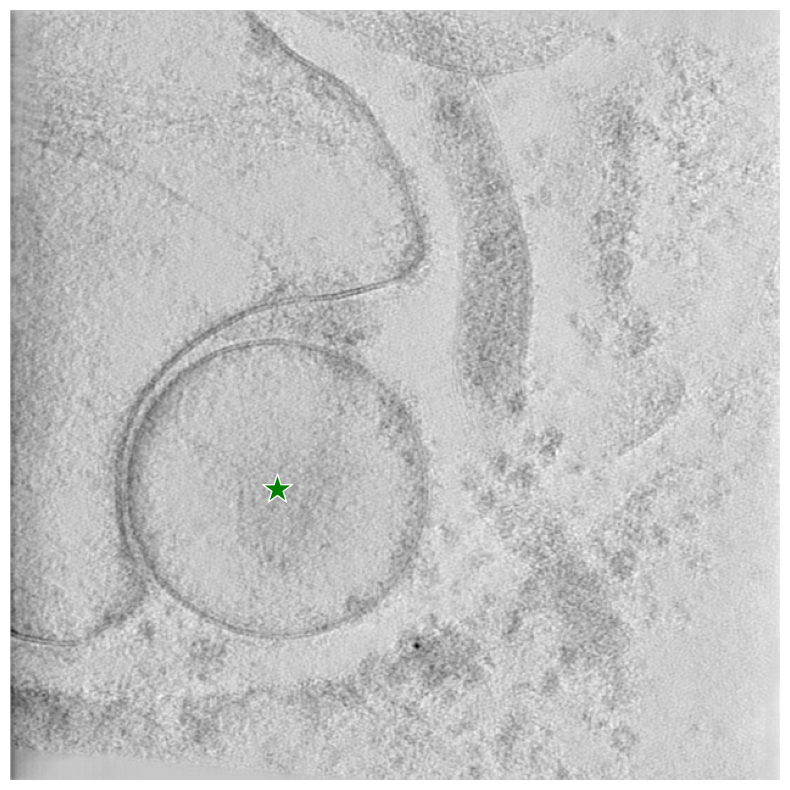

In [7]:
zSlice = int(points[0][0]) 
deltaZ = 50

im = utils.project_tomogram(vol, zSlice, deltaZ) 

plt.figure(figsize=(10,10))
plt.imshow(im, cmap='gray'); plt.axis('off')
plt.scatter(points[:,2], points[:,1], marker='*', c='g',  edgecolor='white', s=500)

#### Option1 : Automatic Mask Generator (Pointless Annotation)

In [128]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.9,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25,
    use_m2m=True,
)


mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2, 
    points_per_side=32,
    points_per_batch=64,    
    pred_iou_thresh=0.8,  
    stability_score_thresh=0.8,
    stability_score_offset=0.85,    
    crop_n_layers=1,
    box_nms_thresh=0.7,   
    crop_n_points_downscale_factor=2,    
    min_mask_region_area=25,  
    use_m2m=True,    
)

Total # of Available Masks:  15
Keys within a Mask:  dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


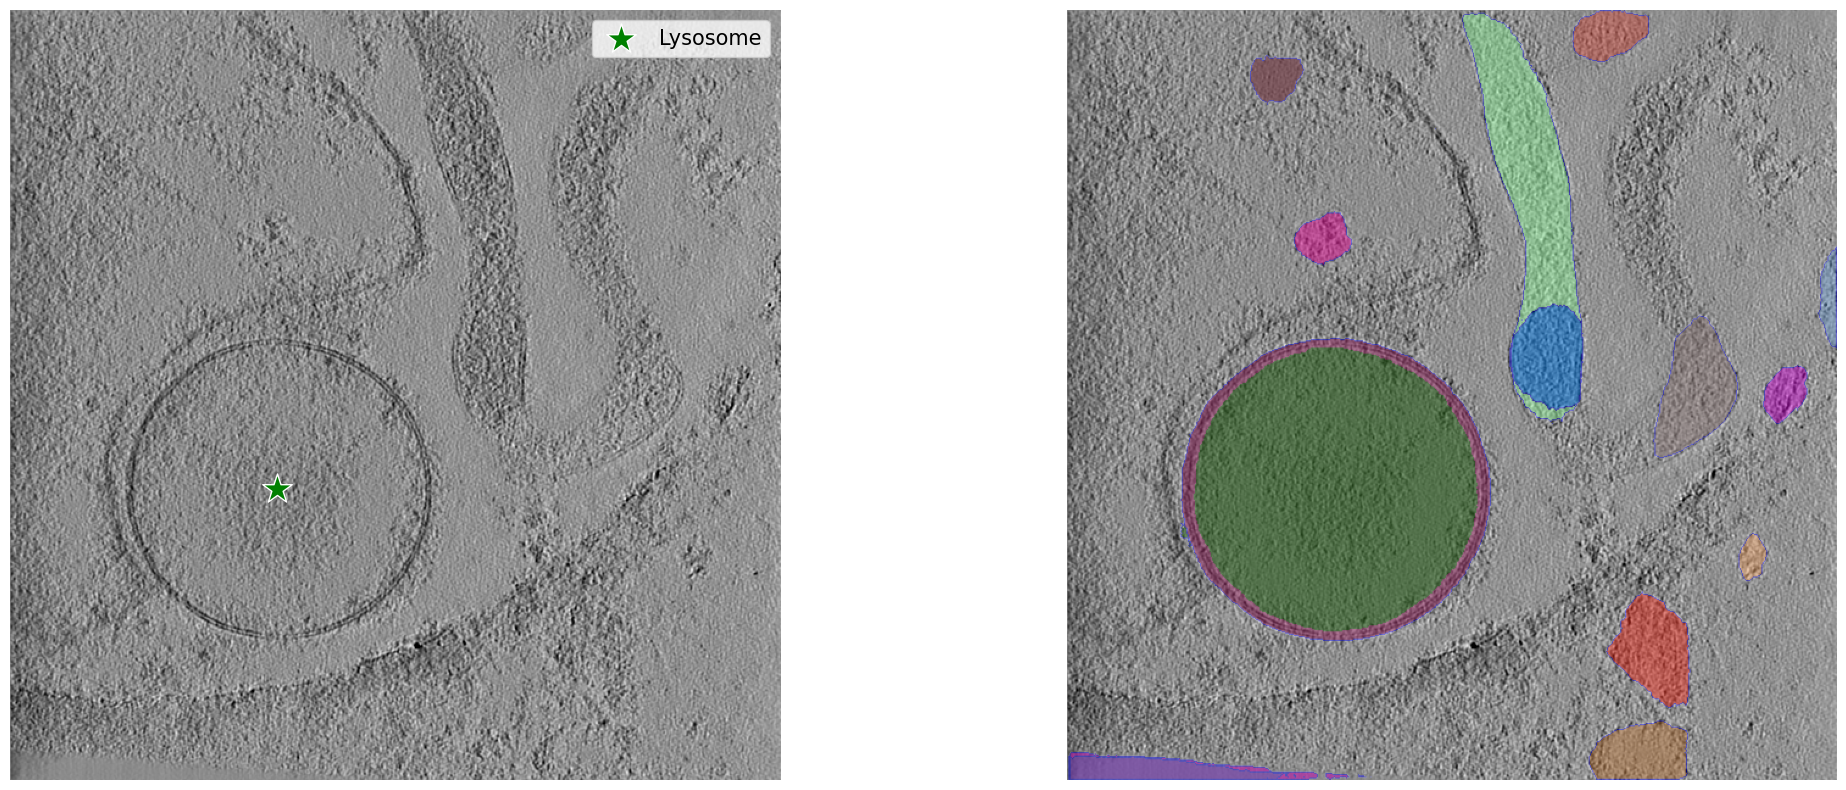

In [131]:
zSlice = int(points[0][0])
# zSlice = None
deltaZ = None
imScale = 1

image = utils.project_tomogram(vol, zSlice, deltaZ) 

# Normalization Tactics

# Option 1: (0,1)
image = imScale * (image - image.min()) / (image.max() - image.min())

# Option 2: (-1,1)
image = image * 2 - 1

# Option 3: Zero Mean, Unit STD
# image -= np.min(image)
# image -= np.mean(image)
# image /= np.std(image)


# Extend From Grayscale to RGB 
image = np.repeat(image[..., None], 3, axis=2)   

# Run Inference from Pre-trained Model
masks = mask_generator.generate(image)

print('Total # of Available Masks: ', len(masks))
print('Keys within a Mask: ', masks[0].keys())

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,10))
ax1.imshow(image, cmap='gray'); ax1.axis('off')
ss = ax1.scatter(points[:,2], points[:,1], marker='*', c='g',  edgecolor='white', s=500)
ax1.legend([ss],['Lysosome'],fontsize='15')

ax2.imshow(image, cmap='gray'); ax1.axis('off')
utils.show_anns(masks)
plt.axis('off')
plt.show() 

#### Option2: Video Segmentation

In [7]:
from sam2.build_sam import build_sam2_tomogram_predictor

sam2_checkpoint = "../segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_tomogram_predictor(model_cfg, sam2_checkpoint, device=device) 

In [8]:
inference_state = predictor.init_state(vol)

100%|██████████| 186/186 [00:05<00:00, 36.07it/s]


In [11]:
zSlice = int(points[0][0])
im = inference_state['images'][zSlice]

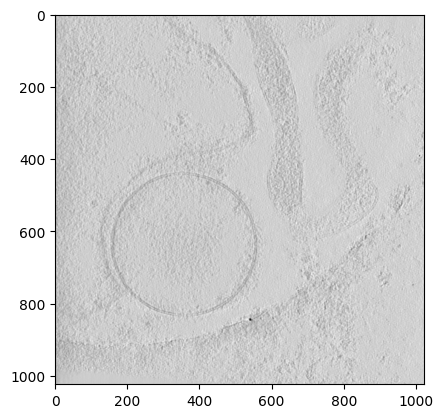

In [14]:
plt.imshow(im.cpu()[0,],cmap='gray')

In [49]:
prompts = {}
ann_frame_idx = int(points[0][0])  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
scale = predictor.image_size / vol.shape[1]
sam_points = np.array([[points[0,2], points[0,1]]], dtype=np.float32) * scale
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=sam_points,
    labels=labels,
)
prompts.setdefault(ann_obj_id, {})
prompts[ann_obj_id].setdefault(ann_frame_idx, [])
prompts[ann_obj_id][ann_frame_idx].append((sam_points, labels))

# show the results on the current (interacted) frame
print(sam_points)
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
utils.show_tomo_frame(inference_state["images"], ann_frame_idx, plt.gca())
utils.show_points(sam_points, labels, plt.gca())
utils.show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

[[354.83545 636.7595 ]]


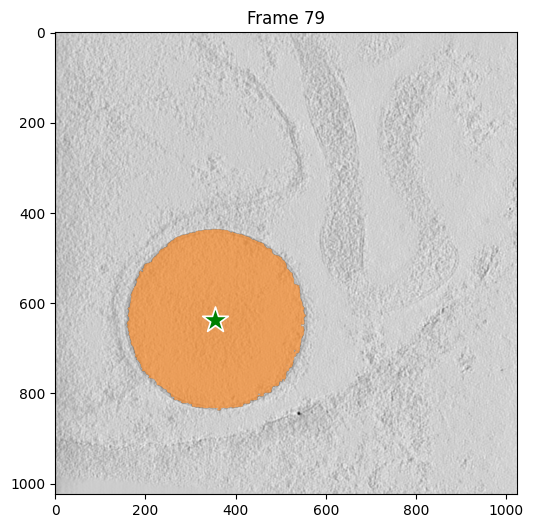

In [50]:
# show the results on the current (interacted) frame
print(sam_points)
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
utils.show_tomo_frame(inference_state["images"], ann_frame_idx, plt.gca())
utils.show_points(sam_points, labels, plt.gca())
utils.show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, start_frame_idx=0):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 50
plt.close("all")
for out_frame_idx in range(0, tomo_data.shape[0], vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    show_tomo_frame(tomo_resized, out_frame_idx, plt.gca())
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [51]:
prompts

{1: {79: [(array([[354.83545, 636.7595 ]], dtype=float32),
    array([1], dtype=int32))]}}

In [47]:
scale = predictor.image_size / vol.shape[1]
print(scale)

1.620253164556962


In [48]:
np.array([[points[0,2], points[0,1]]], dtype=np.float32) * scale

array([[354.83545, 636.7595 ]], dtype=float32)

In [21]:
points

array([[[219.],
        [393.]]], dtype=float32)